In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import sys
sys.path.append('../src')

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd

In [12]:
import celloracle as co

In [13]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
base_GRN

,peak_id,gene_short_name,9430076c15rik,Ac002126.6,Ac012531.1,Ac226150.2,Afp,Ahr,Ahrr,Aire,...,Znf784,Znf8,Znf816,Znf85,Zscan10,Zscan16,Zscan22,Zscan26,Zscan31,Zscan4
0,chr10_100050979_100052296,4930430F08Rik,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_101006922_101007748,SNORA17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,chr10_101144061_101145000,Mgat4c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,chr10_10148873_10149183,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_10149425_10149815,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91971,chrX_99839037_99840900,Phka1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
91972,chrY_345823_347369,Eif2s3y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91973,chrY_581272_582790,Uty,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91974,chrY_621772_623366,Ddx3y,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
import anndata
adata = anndata.read_h5ad('../data/slideseq/day3_1.h5ad')
adata

AnnData object with n_obs × n_vars = 15920 × 24649
    obs: 'cluster', 'rctd_cluster'
    uns: 'cluster_colors', 'rctd_cluster_colors'
    obsm: 'X_spatial', 'rctd_results', 'spatial'

In [15]:
n_top_genes = 3000
min_cells = 10
min_counts = 300

adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
sc.pp.filter_cells(adata, min_counts=min_counts)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
adata = adata[:, ~adata.var["mt"]]
sc.pp.filter_genes(adata, min_cells=min_cells)

adata.layers["raw_count"] = adata.X

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata, flavor="seurat", n_top_genes=n_top_genes)

adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 10277 × 3000
    obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'rctd_cluster_colors', 'log1p', 'hvg'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'raw_count'

In [16]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

2024-08-15 14:55:37.902620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 14:55:38.270760: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 14:55:38.415466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 14:55:39.358705: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 14:56:00.190422: W tensorflow/compiler/tf2

CPU times: user 49.1 s, sys: 3.73 s, total: 52.9 s
Wall time: 1min 21s


In [17]:
sc.tl.paga(adata, groups='rctd_cluster')

In [18]:
plt.rcParams["figure.figsize"] = [6, 6]
sc.pl.paga(adata)

In [19]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)

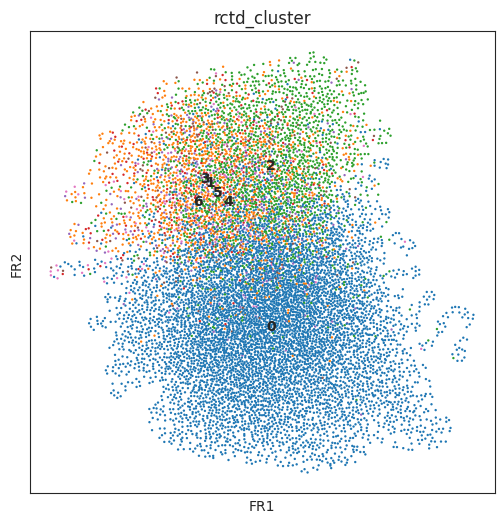

In [20]:
%matplotlib inline
sc.pl.draw_graph(adata, color='rctd_cluster', legend_loc='on data')

In [21]:
oracle = co.Oracle()

In [22]:
adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="rctd_cluster",
    embedding_name="X_draw_graph_fr"
)

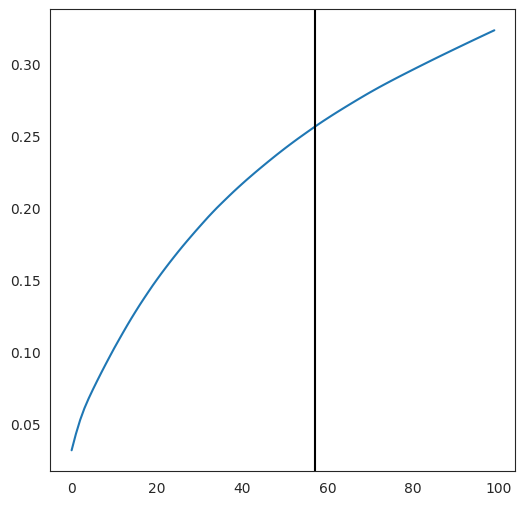

57


In [23]:
%matplotlib inline

# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [24]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :10277


In [25]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :256


In [26]:
oracle.knn_imputation(
    n_pca_dims=n_comps, 
    k=k, 
    balanced=True, 
    b_sight=k*8,
    b_maxl=k*4, 
    n_jobs=4
)

In [27]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [28]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="rctd_cluster", 
    alpha=10,
    verbose_level=10
)

  0%|          | 0/7 [00:00<?, ?it/s]

Inferring GRN for 0...


  0%|          | 0/2381 [00:00<?, ?it/s]

Inferring GRN for 1...


  0%|          | 0/2381 [00:00<?, ?it/s]

Inferring GRN for 2...


  0%|          | 0/2381 [00:00<?, ?it/s]

Inferring GRN for 3...


  0%|          | 0/2381 [00:00<?, ?it/s]

Inferring GRN for 4...


  0%|          | 0/2381 [00:00<?, ?it/s]

Inferring GRN for 5...


  0%|          | 0/2381 [00:00<?, ?it/s]

Inferring GRN for 6...


  0%|          | 0/2381 [00:00<?, ?it/s]

CPU times: user 18min 14s, sys: 15.4 s, total: 18min 29s
Wall time: 22min 56s


In [29]:
links.cluster

[0, 1, 2, 3, 4, 5, 6]

In [30]:
df1 = links.links_dict[1].query('source=="Pax5"')
df2 = links.links_dict[2].query('source=="Pax5"')

In [31]:
celltypes = {
    "0": "B-cell",
    "1": "Cd8 T-cell",
    "2": "Th2",
    "3": "Resting T-cell",
    "4": "Tfh",
    "5": "Treg",
    "6": "NK"
}

In [32]:
# Create a new dictionary with replaced keys
new_links_dict = {}

for key, value in links.links_dict.items():
    if str(key) in celltypes:
        new_key = celltypes[str(key)]
        new_links_dict[new_key] = value
    else:
        new_links_dict[key] = value

# Replace the original links_dict with the new one
links.links_dict = new_links_dict

# Print the new keys to verify the change
print("New keys:", list(links.links_dict.keys()))


New keys: ['B-cell', 'Cd8 T-cell', 'Th2', 'Resting T-cell', 'Tfh', 'Treg', 'NK']


In [33]:
links.links_dict['B-cell']

,source,target,coef_mean,coef_abs,p,-logp
0,Clock,0610030E20Rik,0.000514,0.000514,1.029349e-14,13.987437
1,Mef2a,0610030E20Rik,0.000089,0.000089,1.027639e-03,2.988159
2,Hdac2,0610030E20Rik,0.000151,0.000151,4.763745e-04,3.322051
3,Fos,0610030E20Rik,0.000132,0.000132,6.540265e-05,4.184405
4,Max,0610030E20Rik,0.000132,0.000132,1.958885e-04,3.707991
...,...,...,...,...,...,...
111160,Mafb,Zwilch,-0.000328,0.000328,1.633325e-13,12.786927
111161,Mef2a,Zwilch,0.000060,0.000060,1.955761e-03,2.708684
111162,Xbp1,Zwilch,0.000173,0.000173,4.432973e-09,8.353305
111163,Runx2,Zwilch,0.000142,0.000142,1.113125e-05,4.953456


In [34]:
import pickle

with open('celloracle_links.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

In [35]:
links.links_dict.keys()

dict_keys(['B-cell', 'Cd8 T-cell', 'Th2', 'Resting T-cell', 'Tfh', 'Treg', 'NK'])

In [36]:
# Load the saved links dictionary
with open('celloracle_links.pkl', 'rb') as f:
    loaded_links_dict = pickle.load(f)

# Print the keys to verify the loaded data
print("Loaded keys:", list(loaded_links_dict.keys()))

# Verify that the loaded dictionary matches the original
assert loaded_links_dict.keys() == links.links_dict.keys(), "Loaded dictionary does not match the original"

print("Loaded dictionary matches the original.")

Loaded keys: ['B-cell', 'Cd8 T-cell', 'Th2', 'Resting T-cell', 'Tfh', 'Treg', 'NK']
Loaded dictionary matches the original.


In [37]:
loaded_links_dict['Cd8 T-cell'][loaded_links_dict['Cd8 T-cell'].p < 0.05].query('target=="Cd74"')

,source,target,coef_mean,coef_abs,p,-logp
17734,Mef2c,Cd74,0.077282,0.077282,9.062709e-08,7.042742
17735,Pax5,Cd74,0.120926,0.120926,3.837350e-10,9.415969
17736,Pou2f2,Cd74,0.039520,0.039520,5.686162e-10,9.245181
17737,Egr1,Cd74,-0.035287,0.035287,5.844571e-10,9.233247
17738,Ebf3,Cd74,0.016189,0.016189,5.603729e-14,13.251523
17739,Irf9,Cd74,0.009748,0.009748,5.734480e-07,6.241506
17740,Ebf1,Cd74,0.068127,0.068127,4.259673e-09,8.370624
17741,Gata2,Cd74,0.003684,0.003684,3.629450e-04,3.440159
17742,Tbp,Cd74,-0.007673,0.007673,5.879328e-11,10.230672
17743,Tal1,Cd74,0.005438,0.005438,3.199389e-05,4.494933


In [38]:
pd.DataFrame(
    [df2.set_index('target').loc[np.intersect1d(
        df1.target, df2.target)].coef_mean-df1.set_index('target').loc[
     np.intersect1d(df1.target, df2.target)].coef_mean]).T.sort_values(by='coef_mean', ascending=False)[:20]

,coef_mean
target,
Ccl5,0.034987
Rps24,0.025833
Cd74,0.024044
Lgals1,0.023504
Smc4,0.018540
Iglc3,0.018157
Epsti1,0.017510
Lyz2,0.014814
Clu,0.014394
